# Prediction

## Load preprocessed dataframes

In [47]:
from utils import *

train_df = pd.read_pickle("../out/train.pkl")
test_df = pd.read_pickle("../out/test.pkl")

train_df.head()

,loan_id,amount,duration,payments,status,client_count_per_acc,district_id_account,issuance_frequency_per_month,district_id_client,sex,age,final_amount
0,5314,96396,12,8033,-1,1,30,4.348214,30,0,51,20100.0
1,5316,165960,36,4610,1,1,46,1.000000,46,1,30,52208.9
2,6863,127080,60,2118,1,1,45,1.000000,45,1,62,20272.8
3,5325,105804,36,2939,1,1,12,1.000000,14,0,58,34307.3
4,7240,274740,60,4579,1,1,1,4.348214,63,1,20,41142.9


## Columns to drop and feature target

In [48]:
columns_to_drop = ["loan_id", "status"]
target_column = "status"

train_df.drop(columns_to_drop, axis=1).head()

,amount,duration,payments,client_count_per_acc,district_id_account,issuance_frequency_per_month,district_id_client,sex,age,final_amount
0,96396,12,8033,1,30,4.348214,30,0,51,20100.0
1,165960,36,4610,1,46,1.000000,46,1,30,52208.9
2,127080,60,2118,1,45,1.000000,45,1,62,20272.8
3,105804,36,2939,1,12,1.000000,14,0,58,34307.3
4,274740,60,4579,1,1,4.348214,63,1,20,41142.9


## Tune Models

### Decision Tree

Best score: 0.7448245073891625
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'splitter': 'best'}


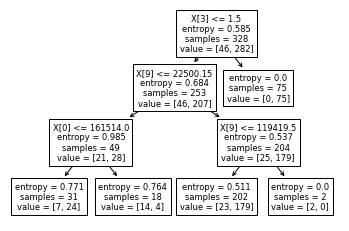

In [49]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 7)
}

# No feature selection
dt = tune_model(
    train_df, 
    DecisionTreeClassifier(),
    parameter_grid, 
    columns_to_drop, 
    target_column
)

plot_tree(dt.best_estimator_);

### SVM
Needs to be scaled (StandardScaler)

In [50]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

parameter_grid = {
    'C': [1, 10, 50],
    'gamma': [0.001, 0.0001],
    # 'kernel': ['linear', 'poly', 'rbf']
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# No feature selection
svc = tune_model(
    train_df, 
    SVC(probability=True), 
    parameter_grid,
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler()
)

svc.best_estimator_

Best score: 0.7292795566502464
Best parameters: {'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}


SVC(C=50, gamma=0.001, probability=True)

###  K-nearest neighbours (KNN)
Just like the SVM model, the KNN model also requires the data to be scaled.

In [51]:
from sklearn import neighbors

parameter_grid = {
    'n_neighbors': [4, 5, 6, 7, 10, 15],
    'leaf_size': [5, 10, 15, 20, 50, 100],
    'n_jobs': [-1],
    'algorithm': ['auto']
}

# No feature selection
knn = neighbors.KNeighborsClassifier()
knn = tune_model(
    train_df, 
    neighbors.KNeighborsClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler()
)

Best score: 0.6699722906403941
Best parameters: {'algorithm': 'auto', 'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 15}


### Naïve Bayes

In [52]:
from sklearn.naive_bayes import GaussianNB

parameter_grid = {}

# No feature selection
nb = tune_model(
    train_df, 
    GaussianNB(),
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler()
)

Best score: 0.7234729064039409
Best parameters: {}


### Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

parameter_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15],
    'n_jobs': [-1],  # Use all cores
    'criterion': ['gini', 'entropy']
}

# No feature selection
rfc = tune_model(
    train_df, 
    RandomForestClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column
)

Best score: 0.7557450738916256
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50, 'n_jobs': -1}


## Comparing Models

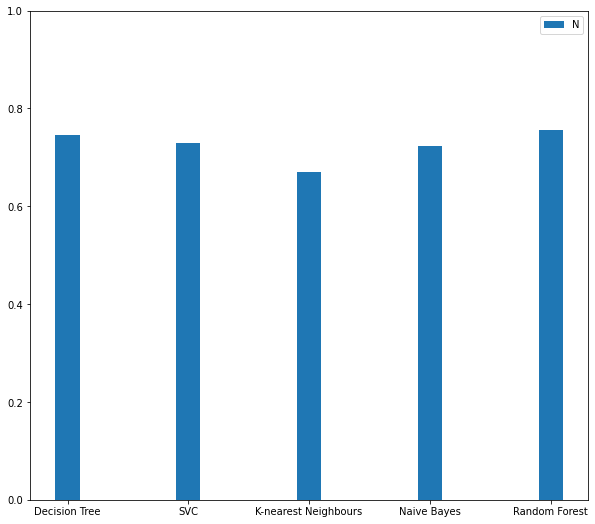

In [54]:
scores = {
    "Decision Tree" : [dt], #[dt_original, dt, dt_os_fs],
    "SVC" : [svc], #[svc_original, svc, svc_os_fs],
    "K-nearest Neighbours" : [knn], #[knn_original, knn, knn_os_fs],
    "Naive Bayes" : [nb], #[nb_original, nb, nb_os_fs],
    "Random Forest" : [rfc], #[rfc_original, rfc, rfc_os_fs]
}

labels = "No Feature selection" # ["No oversampling/No feature selection","No oversampling/Feature selection", "Oversampling/Feature selection"]

ind = np.arange(5)

plt.figure(figsize=(10,9))
plt.bar(ind, [i[0].best_score_ for i in scores.values()], 0.2)
# ax = plt.bar(ind + 0.2, [i[1].best_score_ for i in scores.values()], 0.2)
# ax = plt.bar(ind + 0.4, [i[2].best_score_ for i in scores.values()], 0.2)
plt.xticks(ind, scores.keys())
plt.legend(labels, loc=1)
plt.ylim(0, 1)
plt.show()

## Save results

In [55]:
X_result = test_df.drop(columns_to_drop, axis=1)

y_result = rfc.predict_proba(X_result)[:, 0]

result = pd.DataFrame({"Id": test_df["loan_id"], "Predicted": y_result})
result.drop_duplicates(inplace=True)
result.to_csv("../out/result.csv", index=False)